In [1]:
import toml
import joblib
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt

from scipy import signal
from os.path import join
from toolz import partial
from tqdm.auto import tqdm
from collections import defaultdict
from rl_analysis import ANALYSIS_CONFIG
from tqdm.contrib.concurrent import process_map
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.plotting import save_factory, setup_plotting_env, fg, clean_ticks
from rl_analysis.io.df import NONSYLL_COLS, dlight_exclude_toml, load_dlight_features

warnings.simplefilter('ignore')

In [2]:
def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.0), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser


def compute_shuffle(i, df, waveform_func, dlight_key="signal_reref_dff_z", shuff_key="shuff_da"):
    df = df.copy()
    df[shuff_key] = df.groupby("uuid", sort=False, observed=True)[dlight_key].transform(
        lambda v: np.roll(v, random.randint(1, len(v) - 1))
    )
    result = waveform_func(df, shuff_key)
    return pd.concat({i: result}, names=["shuffle"])

In [3]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [4]:
setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'variability-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

dlight_key = "dlight filtered"

In [5]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

In [6]:
df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df["session_number"].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df["offline onset"] = False
df.loc[df.index[syll_onset(df["predicted_syllable (offline)"])], "offline onset"] = True
df[dlight_key] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [7]:
sorting = joblib.load(join(config['intermediate_results']['dlight'], 'fig1-syllable-sorting.p'))

In [8]:
time_window = (-1.5, 1.5)

In [9]:
feat_df = load_dlight_features(join(config['intermediate_results']['dlight'], 'dlight-chrimson_snippets_offline_features.parquet'))
feat_df = feat_df[feat_df['uuid'].isin(use_dct)]

## Plot heatmap of mouse and syllable sorted dLight waveforms

In [10]:
def compute_syllable_session_waveforms(df, dlight_key):
    out = {}
    # for uuid, uuid_df in df.groupby("uuid", observed=True, sort=False):
    for uuid, uuid_df in df.groupby("mouse_id", observed=True, sort=False):
        for syll in sorting:
            inds = np.where(uuid_df["offline onset"] & (uuid_df['predicted_syllable (offline)'] == syll))[0]
            time, trials = window_trials_as_mtx(
                uuid_df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
            )
            out[(uuid, syll)] = pd.Series(np.nanmean(trials, axis=0), index=pd.Index(time, name='time'))
    return pd.DataFrame(out)

In [11]:
n_shuffles = 1_000
shuff_key = "shuff_da"

results = process_map(
    partial(
        compute_shuffle,
        df=df[["mouse_id", "uuid", dlight_key, "offline onset", "predicted_syllable (offline)"]],
        waveform_func=compute_syllable_session_waveforms,
        dlight_key=dlight_key,
        shuff_key=shuff_key,
    ),
    range(n_shuffles),
    max_workers=6,
)

# SAVE SHUFFLES
joblib.dump(
    results,
    join(config['intermediate_results']['dlight'], 'figs4-filtered-session-syllable-waveform-shuffles-per-mouse.p'),
)

  0%|          | 0/1000 [00:00<?, ?it/s]

['/n/groups/datta/win/dopamine-data-release/zenodo-test/dlight_intermediate_results/figs4-filtered-session-syllable-waveform-shuffles-per-mouse.p']

In [12]:
# uncomment if you've saved the results previously
# results = joblib.load(join(config['intermediate_results']['dlight'], 'figs4-filtered-session-syllable-waveform-shuffles-per-mouse.p'))

In [13]:
shuff_df = pd.concat(results)

In [18]:
waveforms = defaultdict(list)
peaks = defaultdict(list)

gb = shuff_df.groupby('time')

for k, _df in tqdm(df.groupby('mouse_id', sort=True, observed=True)):
    for syll in sorting:
        inds = np.where((_df['predicted_syllable (offline)'] == syll) & _df['offline onset'])[0]
        if len(inds) > 0:
            time, mtx = window_trials_as_mtx(_df, inds, dlight_key, truncation_window=time_window)

            sm = gb[[(k, syll)]].mean().to_numpy().squeeze()
            ss = gb[[(k, syll)]].std().to_numpy().squeeze()
            waveforms[syll].append(((np.nanmean(mtx, axis=0) - sm) / ss))

            wf = waveforms[syll][-1]
            peak = np.nanmax(wf[(time >= 0) & (time <= 0.3)])
            peaks[syll].append(peak)

waveforms = dict(waveforms)
peaks = dict(peaks)

  0%|          | 0/14 [00:00<?, ?it/s]

In [20]:
all_peaks = np.concatenate([peaks[k] for k in sorting])

everything = np.concatenate([waveforms[k] for k in sorting], axis=0)
mask = np.all(np.isnan(everything), axis=1)

# show re-ordered syll labels
syll_labels = []
for k in sorting:
    syll_labels.extend(np.repeat([sorting[k]], len(waveforms[k])))
syll_labels = np.array(syll_labels)

everything = everything[~mask]
syll_labels = syll_labels[~mask]
all_peaks = all_peaks[~mask]

cumulative = pd.Series(syll_labels).value_counts().reindex(sorting.values())
boundaries = cumulative.cumsum()

sylls, counts = np.unique(syll_labels, return_counts=True)
offset = counts[0] // 2

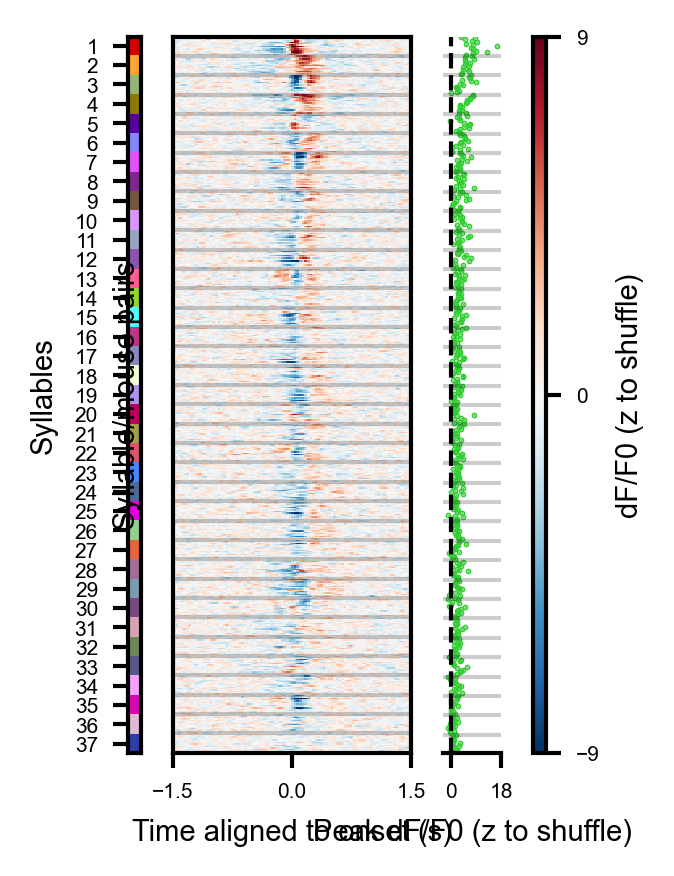

In [21]:
color_range = 9
fig, ax_dict = plt.subplot_mosaic(
    "ABBBBBBCCD",
    figsize=(1.8, 3.1),
)
fig.dpi = 150
ax_dict["A"].imshow(
    syll_labels[:, None],
    aspect="auto",
    cmap=cc.cm.glasbey,
    extent=(0, 1, len(everything) - 0.5, 0.5),
    interpolation="none", 
)
ax_dict["A"].set(
    xticks=[],
    ylabel="Syllables",
    yticks=np.linspace(offset, len(syll_labels) - offset, len(sorting)),
    yticklabels=map(lambda x: x + 1, sorting.values()),
)
im = ax_dict["B"].imshow(
    everything,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-color_range,
    vmax=color_range,
    extent=(time[0], time[-1], len(everything), 0),
    interpolation="none",
)
ax_dict["B"].set(
    xlabel="Time aligned to onset (s)",
    ylabel="Syllable/mouse pairs",
    yticks=[],
    xticks=[time[0], 0, time[-1]],
)
for _, v in boundaries.iteritems():
    ax_dict["B"].axhline(v, lw=1, ls="-", c="k", alpha=0.2)
ax_dict["C"].plot(all_peaks, np.arange(len(all_peaks)), ".", c="limegreen", ms=0.75)
ax_dict["C"].axvline(0, lw=1, ls="--", c="k")
ax_dict["C"].set(ylim=(0, len(all_peaks) - 1), yticks=[], xlabel="Peak dF/F0 (z to shuffle)", xlim=(-3, 18), xticks=[0, 18])
ax_dict["C"].invert_yaxis()
for _, v in boundaries.iteritems():
    ax_dict["C"].axhline(v, lw=1, ls="-", c="k", alpha=0.2)
sns.despine(ax=ax_dict["C"], left=True)

cb = fig.colorbar(im, cax=ax_dict["D"], label="dF/F0 (z to shuffle)", aspect=60)
cb.set_ticks([-color_range, 0, color_range])
plt.subplots_adjust(wspace=2.5)

saver(fig, "avg-filtered-dlight-waveforms-for-all-syllables-and-mice-z");

## Breakout some syllables

In [22]:
breakouts = np.array(list(sorting))[[1, 12, -3]]
breakouts

array([ 5, 86, 25])

In [23]:
waveforms = defaultdict(list)

for k, _df in tqdm(df.groupby('mouse_id', sort=False, observed=True)):
    for syll in breakouts:
        inds = np.where((_df['predicted_syllable (offline)'] == syll) & _df['offline onset'])[0]
        if len(inds) > 0:
            time, mtx = window_trials_as_mtx(_df, inds, dlight_key, truncation_window=time_window)
            sm = gb[[(k, syll)]].mean().to_numpy().squeeze()
            ss = gb[[(k, syll)]].std().to_numpy().squeeze()
            waveforms[syll].append(((np.nanmean(mtx, axis=0) - sm) / ss))
            # grab avg peak DA
waveforms = dict(waveforms)

  0%|          | 0/14 [00:00<?, ?it/s]

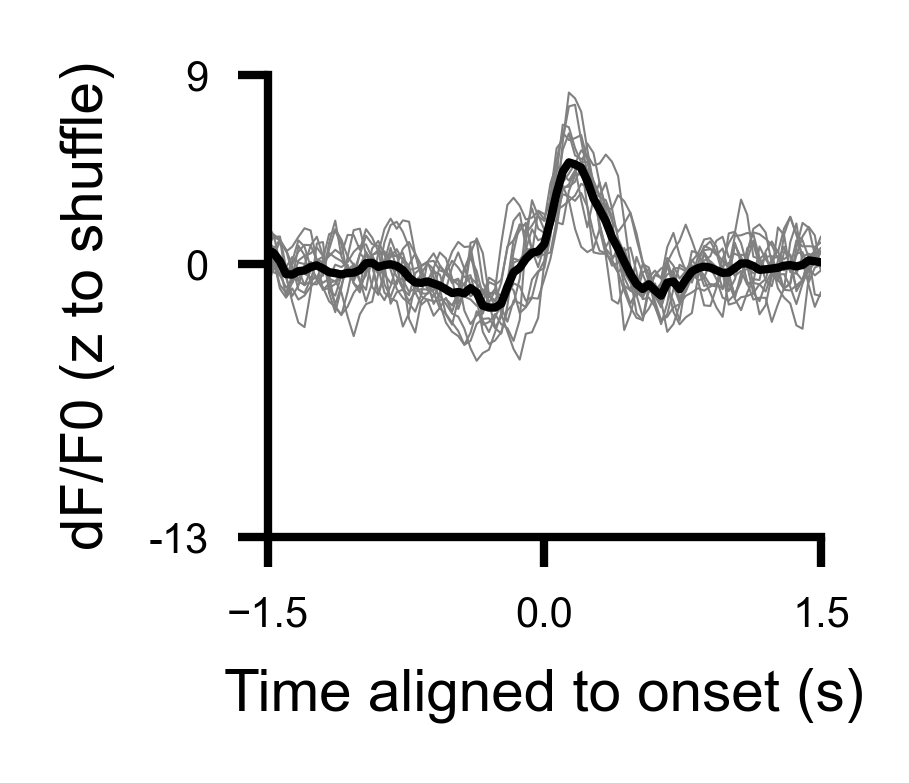

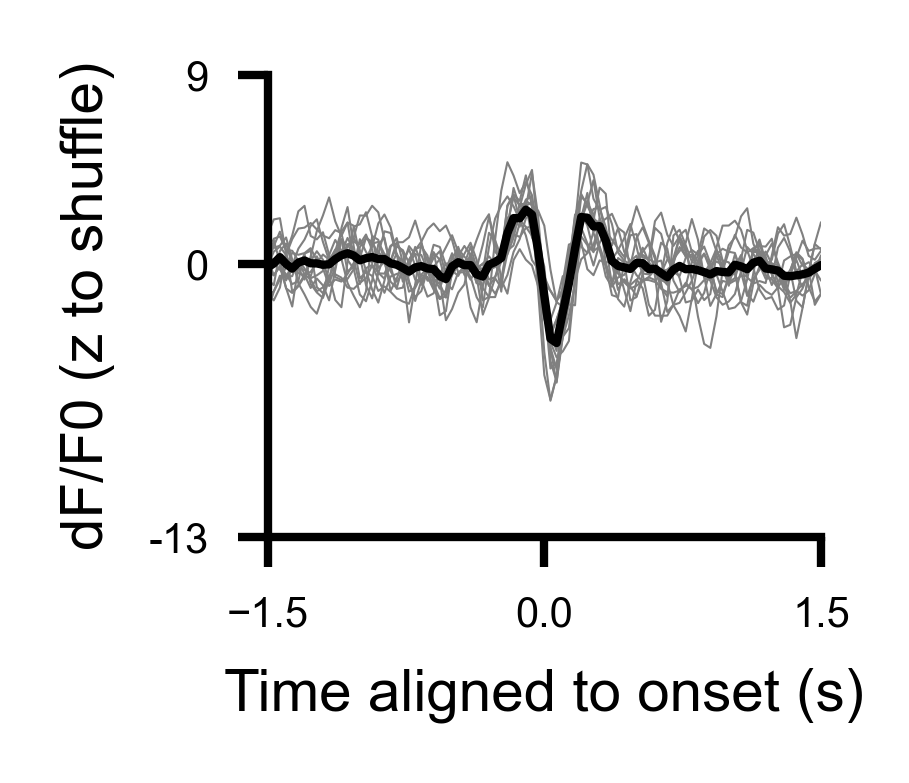

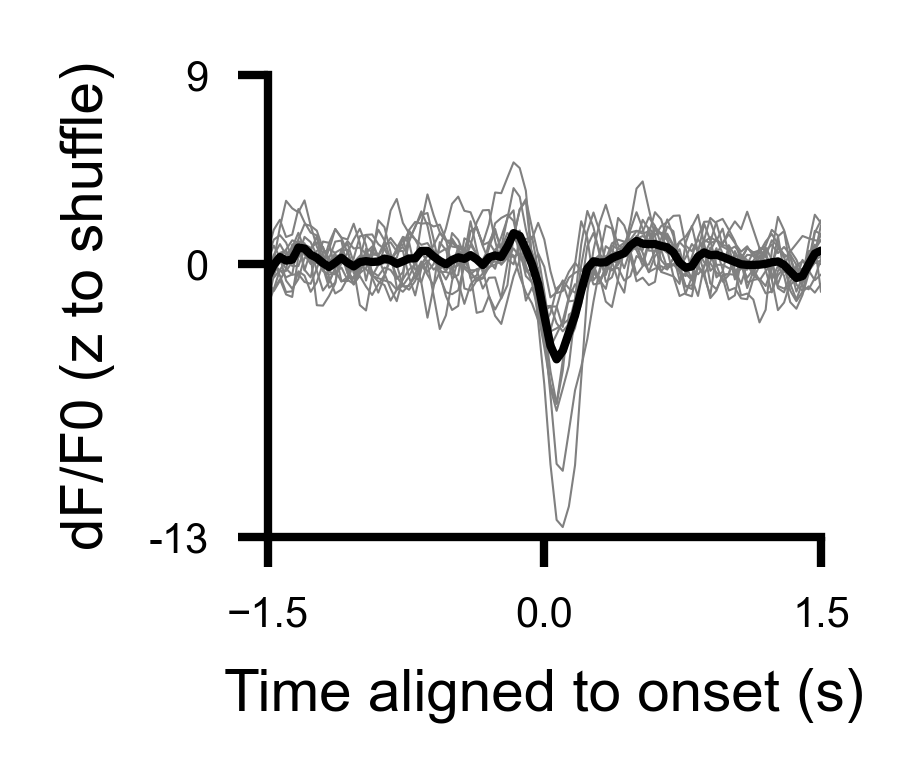

In [24]:
for k, v in waveforms.items():
    fig = fg(1.19, 1)
    fig.dpi = 300
    ax = fig.gca()
    ax.plot(time, np.array(v).T, lw=0.25, c="gray", alpha=1)
    ax.plot(time, np.nanmean(v, axis=0), lw=1, c="k")
    ax.set(
        xlim=time_window,
        xlabel="Time aligned to onset (s)",
        ylabel="dF/F0 (z to shuffle)",
        xticks=(time_window[0], 0, time_window[1]),
        ylim=(-13, 9),
    )
    clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int)
    sns.despine()
    saver(fig, f"filtered-syllable-callout-{k}-per-mouse-z");